In [289]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split

DATA_DIR = "quickdraw_images_dedup"
MAX_PER_CLASS = 5000
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
SEED = 42

np.random.seed(SEED)

class_names = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])

class_to_idx = {cls: i for i, cls in enumerate(class_names)}

print(f"[INFO] Found {len(class_names)} classes")

X = []
y = []

for cls in class_names:
    cls_path = os.path.join(DATA_DIR, cls)
    label = class_to_idx[cls]

    files = os.listdir(cls_path)
    np.random.shuffle(files)
    files = files[:MAX_PER_CLASS]

    for fname in files:
        fpath = os.path.join(cls_path, fname)

        # Load as raw grayscale
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        X.append(img)
        y.append(label)

X = np.array(X, dtype=object)
y = np.array(y)

print(f"[INFO] Total samples loaded: {len(X)}")

#Train Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=TEST_SPLIT + VAL_SPLIT,
    stratify=y,
    random_state=SEED
)

val_ratio = VAL_SPLIT / (TEST_SPLIT + VAL_SPLIT)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio,
    stratify=y_temp,
    random_state=SEED
)

print("[INFO] Split summary:")
print("  Train:", len(X_train))
print("  Val  :", len(X_val))
print("  Test :", len(X_test))

# Save class Map
with open("class_map.json", "w") as f:
    json.dump(class_to_idx, f, indent=2)

print("[INFO] Data loading stage complete")

[INFO] Found 8 classes
[INFO] Total samples loaded: 40000
[INFO] Split summary:
  Train: 28000
  Val  : 6000
  Test : 6000
[INFO] Data loading stage complete


In [ ]:
import cv2
import numpy as np
import random

IMG_SIZE = 224

def preprocess_image(img, size=IMG_SIZE, augment=False):
    if img is None:
        return np.full((size, size), 255, dtype=np.uint8)

    img = np.asarray(img, dtype=np.uint8)

    # Optional Augmentation
    if augment:
        h, w = img.shape
        angle = random.uniform(-8, 8)
        scale = random.uniform(0.95, 1.05)
        tx = random.uniform(-0.05, 0.05) * w
        ty = random.uniform(-0.05, 0.05) * h

        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, scale)
        M[0, 2] += tx
        M[1, 2] += ty

        img = cv2.warpAffine(
            img, M, (w, h),
            flags=cv2.INTER_LINEAR,
            borderValue=255
        )

    # Find INK Bbox
    ys, xs = np.where(img < 200)
    if len(xs) == 0:
        return np.full((size, size), 255, dtype=np.uint8)

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    cropped = img[y_min:y_max+1, x_min:x_max+1]

    # Scale longest side
    h, w = cropped.shape
    scale = size / max(h, w)
    new_h = int(h * scale)
    new_w = int(w * scale)

    resized = cv2.resize(
        cropped, (new_w, new_h),
        interpolation=cv2.INTER_AREA
    )

    # Center on white canvas
    canvas = np.full((size, size), 255, dtype=np.uint8)
    y_off = (size - new_h) // 2
    x_off = (size - new_w) // 2
    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized

    # Gaussian Blur
    canvas = cv2.GaussianBlur(canvas, (3, 3), 0)

    #Contrast Normalization
    canvas = cv2.normalize(canvas, None, 0, 255, cv2.NORM_MINMAX)

    return canvas


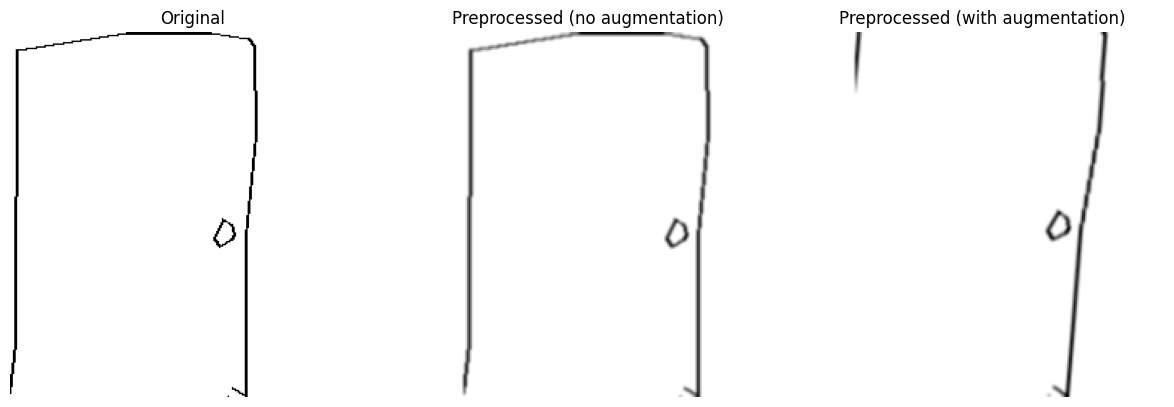

In [292]:
import matplotlib.pyplot as plt
import numpy as np

img_raw = X_train[2]
img_raw = np.asarray(img_raw, dtype=np.uint8)

img_clean = preprocess_image(img_raw, augment=False)
img_aug   = preprocess_image(img_raw, augment=True)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_raw, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Preprocessed (no augmentation)")
plt.imshow(img_clean, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Preprocessed (with augmentation)")
plt.imshow(img_aug, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [293]:
def preprocess_batch(X, augment=False):
    return np.array(
        [preprocess_image(img, augment=augment) for img in X],
        dtype=np.uint8
    )


In [294]:
X_train_pp = preprocess_batch(X_train, augment=True)
X_val_pp   = preprocess_batch(X_val, augment=True)
X_test_pp  = preprocess_batch(X_test, augment=False)

print("[INFO] Preprocessing complete")
print("Train:", X_train_pp.shape)
print("Val  :", X_val_pp.shape)
print("Test :", X_test_pp.shape)

[INFO] Preprocessing complete
Train: (28000, 224, 224)
Val  : (6000, 224, 224)
Test : (6000, 224, 224)


In [ ]:
import numpy as np
import cv2


#HOG
def gradient_orientation_histogram(img, num_bins=9):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    magnitude = np.sqrt(gx**2 + gy**2)
    angle = (np.arctan2(gy, gx) * 180 / np.pi) % 180

    bin_width = 180 / num_bins
    hist = np.zeros(num_bins, dtype=np.float32)

    for i in range(num_bins):
        mask = (angle >= i * bin_width) & (angle < (i + 1) * bin_width)
        hist[i] = np.sum(magnitude[mask])

    hist /= (np.linalg.norm(hist) + 1e-6)
    return hist


In [296]:
def grid_density(img, grid=7):
    h, w = img.shape
    gh, gw = h // grid, w // grid

    features = []

    for i in range(grid):
        for j in range(grid):
            cell = img[i*gh:(i+1)*gh, j*gw:(j+1)*gw]
            density = np.mean(cell > 0)
            features.append(density)

    return np.array(features, dtype=np.float32)


In [297]:
def gradient_magnitude_stats(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    mag = np.sqrt(gx**2 + gy**2)

    stats = [
        np.mean(mag),
        np.std(mag),
        np.max(mag),
        np.percentile(mag, 75)
    ]

    return np.array(stats, dtype=np.float32)


In [298]:
def contour_features(img):
    _, bin_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return np.zeros(5, dtype=np.float32)

    cnt = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    bbox = cv2.boundingRect(cnt)
    aspect_ratio = bbox[2] / (bbox[3] + 1e-6)
    compactness = (perimeter**2) / (area + 1e-6)

    return np.array([
        area,
        perimeter,
        aspect_ratio,
        compactness,
        len(cnt)
    ], dtype=np.float32)


In [299]:
def raw_moment_features(img):
    m = cv2.moments(img)
    feats = [
        m["m00"],
        m["m10"] / (m["m00"] + 1e-6),
        m["m01"] / (m["m00"] + 1e-6),
        m["mu20"],
        m["mu02"],
        m["mu11"]
    ]
    return np.array(feats, dtype=np.float32)


In [ ]:
def stroke_transition_features(img):
    img_bin = (img > 0).astype(np.uint8)

    h_trans = np.sum(img_bin[:, 1:] != img_bin[:, :-1])

    v_trans = np.sum(img_bin[1:, :] != img_bin[:-1, :])

    d1 = np.sum(img_bin[1:, 1:] != img_bin[:-1, :-1])
    d2 = np.sum(img_bin[1:, :-1] != img_bin[:-1, 1:])

    return np.array([
        h_trans,
        v_trans,
        d1,
        d2
    ], dtype=np.float32)


In [301]:
def normalized_moment_features(img):
    img = img.astype(np.float32)
    total = img.sum() + 1e-6

    y, x = np.indices(img.shape)
    x_bar = (x * img).sum() / total
    y_bar = (y * img).sum() / total

    mu20 = ((x - x_bar)**2 * img).sum() / total
    mu02 = ((y - y_bar)**2 * img).sum() / total
    mu11 = ((x - x_bar)*(y - y_bar) * img).sum() / total

    return np.array([mu20, mu02, mu11], dtype=np.float32)


In [ ]:
def curvature_features(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    angles = np.arctan2(gy, gx)
    angles = angles[img > 0]

    if angles.size < 2:
        return np.zeros(2, dtype=np.float32)

    dtheta = np.diff(angles)

    return np.array([
        np.mean(np.abs(dtheta)),
        np.std(dtheta)
    ], dtype=np.float32)


In [303]:
def shape_ratio_features(img):
    ys, xs = np.where(img > 0)
    if len(xs) == 0:
        return np.zeros(3, dtype=np.float32)

    width = xs.max() - xs.min() + 1
    height = ys.max() - ys.min() + 1
    area = len(xs)

    aspect = width / (height + 1e-6)
    compactness = area / (width * height + 1e-6)

    return np.array([
        aspect,
        1.0 / (aspect + 1e-6),
        compactness
    ], dtype=np.float32)


In [304]:
def endpoint_features(img):
    bin_img = (img > 0).astype(np.uint8)
    h, w = bin_img.shape

    endpoints = 0
    junctions = 0

    for y in range(1, h-1):
        for x in range(1, w-1):
            if bin_img[y, x]:
                neighbors = np.sum(bin_img[y-1:y+2, x-1:x+2]) - 1
                if neighbors == 1:
                    endpoints += 1
                elif neighbors >= 3:
                    junctions += 1

    return np.array([
        endpoints,
        junctions
    ], dtype=np.float32)


In [305]:
def ink_ratio_feature(img):
    return np.array([
        np.mean(img > 0)
    ], dtype=np.float32)


In [306]:
def hv_stroke_ratio(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    abs_gx = np.mean(np.abs(gx))
    abs_gy = np.mean(np.abs(gy))

    return np.array([
        abs_gx,
        abs_gy,
        abs_gx / (abs_gy + 1e-6)
    ], dtype=np.float32)


In [307]:
def quadrant_density(img):
    h, w = img.shape
    h2, w2 = h // 2, w // 2

    q1 = np.mean(img[:h2, :w2] > 0)
    q2 = np.mean(img[:h2, w2:] > 0)
    q3 = np.mean(img[h2:, :w2] > 0)
    q4 = np.mean(img[h2:, w2:] > 0)

    return np.array([q1, q2, q3, q4], dtype=np.float32)


In [308]:
def edge_density_feature(img):
    edges = cv2.Canny(img, 50, 150)
    return np.array([
        np.mean(edges > 0)
    ], dtype=np.float32)


In [309]:
def spatial_orientation(img, grid):
    h, w = img.shape
    cell_h = h // grid
    cell_w = w // grid

    feats = []
    for i in range(grid):
        for j in range(grid):
            patch = img[
                i*cell_h:(i+1)*cell_h,
                j*cell_w:(j+1)*cell_w
            ]
            feats.append(gradient_orientation_histogram(patch))
    return np.concatenate(feats)


In [ ]:
def extract_features_manual(img):
    feats = []

    # Global Orientation
    feats.append(gradient_orientation_histogram(img))

    # Spatial Orientation 2x2
    feats.append(spatial_orientation(img, grid=2))

    # Spatial Orientation
    feats.append(spatial_orientation(img, grid=4))

    # Multi Scale Grade Density
    feats.append(grid_density(img, grid=5))
    feats.append(grid_density(img, grid=7))

    # Gradient Magnitude Statistic
    feats.append(gradient_magnitude_stats(img))
    # print("test: ", len(np.concatenate(feats)))

    #Fast Shape
    feats.append(ink_ratio_feature(img))
    feats.append(hv_stroke_ratio(img))
    feats.append(quadrant_density(img))
    feats.append(edge_density_feature(img))
    # print("test2: ", len(np.concatenate(feats)))

    #Shape Geometry
    feats.append(normalized_moment_features(img))
    # print("test3: ", len(np.concatenate(feats)))
    feats.append(shape_ratio_features(img))

    return np.concatenate(feats)


In [344]:
def extract_features_batch(X):
    return np.vstack([extract_features_manual(img) for img in X])


In [ ]:
X_train_feat = extract_features_batch(X_train_pp)
X_val_feat   = extract_features_batch(X_val_pp)
X_test_feat  = extract_features_batch(X_test_pp)

print("[INFO] Feature extraction complete")
print("Train features:", X_train_feat.shape)
print("Val features  :", X_val_feat.shape)
print("Test features :", X_test_feat.shape)


[INFO] Feature extraction complete
Train features: (28000, 282)
Val features  : (6000, 282)
Test features : (6000, 282)


In [346]:
#Fetaure Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_feat_norm = scaler.fit_transform(X_train_feat)
X_val_feat_norm   = scaler.transform(X_val_feat)
X_test_feat_norm  = scaler.transform(X_test_feat)

print("[INFO] Feature normalization complete")

[INFO] Feature normalization complete


In [362]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(0.1)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.drop3(F.relu(self.bn3(self.fc3(x))))
        return self.out(x) / 1.5


In [363]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_feat_norm, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

X_val_t = torch.tensor(X_val_feat_norm, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

X_test_t = torch.tensor(X_test_feat_norm, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)


In [356]:
print(torch.__version__)

1.13.1+cpu


In [364]:
import torch
import torch.nn as nn

num_classes = int(np.max(y_train)) + 1
print(num_classes)
input_dim = X_train_feat_norm.shape[1]

model = MLPClassifier(
    input_dim=input_dim,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


8


In [365]:
def train_one_epoch(model, X, y, optimizer, criterion, batch_size=128):
    model.train()
    perm = torch.randperm(X.size(0))
    total_loss = 0.0
    correct = 0

    for i in range(0, X.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb = X[idx]
        yb = y[idx]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()

    avg_loss = total_loss / X.size(0)
    acc = correct / X.size(0)
    return avg_loss, acc

In [366]:
def evaluate(model, X, y):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        logits = model(X)
        loss = nn.CrossEntropyLoss()(logits, y)

        preds = logits.argmax(dim=1)
        correct = (preds == y).sum().item()
        total_loss = loss.item() * X.size(0)

    avg_loss = total_loss / X.size(0)
    acc = correct / X.size(0)
    return avg_loss, acc


In [ ]:
epochs = 30
batch_size = 128
patience = 5

best_val_acc = 0.0
best_state = None
wait = 0

train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(
        model, X_train_t, y_train_t,
        optimizer, criterion,
        batch_size=batch_size
    )

    val_loss, val_acc = evaluate(model, X_val_t, y_val_t)

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Wait: {wait}/{patience}"
    )

    if wait >= patience:
        print("Early stopping triggered")
        break

model.load_state_dict(best_state)


Epoch 001 | Train Acc: 0.7338 | Val Acc: 0.8730 | Wait: 0/5
Epoch 002 | Train Acc: 0.8830 | Val Acc: 0.8983 | Wait: 0/5
Epoch 003 | Train Acc: 0.9027 | Val Acc: 0.9105 | Wait: 0/5
Epoch 004 | Train Acc: 0.9142 | Val Acc: 0.9168 | Wait: 0/5
Epoch 005 | Train Acc: 0.9205 | Val Acc: 0.9223 | Wait: 0/5
Epoch 006 | Train Acc: 0.9256 | Val Acc: 0.9243 | Wait: 0/5
Epoch 007 | Train Acc: 0.9300 | Val Acc: 0.9280 | Wait: 0/5
Epoch 008 | Train Acc: 0.9352 | Val Acc: 0.9308 | Wait: 0/5
Epoch 009 | Train Acc: 0.9364 | Val Acc: 0.9327 | Wait: 0/5
Epoch 010 | Train Acc: 0.9386 | Val Acc: 0.9320 | Wait: 1/5
Epoch 011 | Train Acc: 0.9420 | Val Acc: 0.9337 | Wait: 0/5
Epoch 012 | Train Acc: 0.9455 | Val Acc: 0.9333 | Wait: 1/5
Epoch 013 | Train Acc: 0.9455 | Val Acc: 0.9335 | Wait: 2/5
Epoch 014 | Train Acc: 0.9475 | Val Acc: 0.9335 | Wait: 3/5
Epoch 015 | Train Acc: 0.9490 | Val Acc: 0.9320 | Wait: 4/5
Epoch 016 | Train Acc: 0.9510 | Val Acc: 0.9328 | Wait: 5/5
Early stopping triggered


<All keys matched successfully>

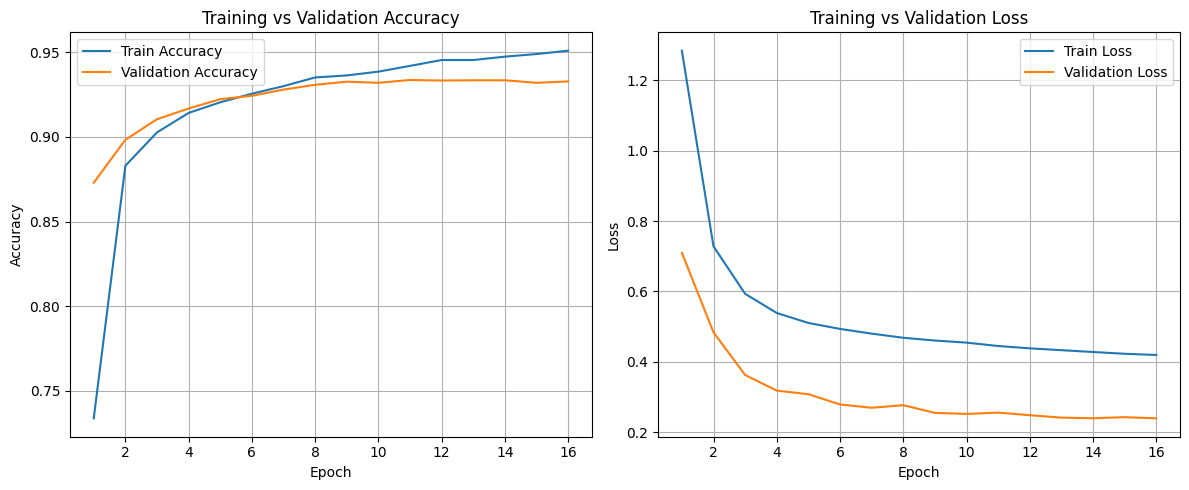

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_acc_hist) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_hist, label="Train Accuracy")
plt.plot(epochs_range, val_acc_hist, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_hist, label="Train Loss")
plt.plot(epochs_range, val_loss_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = evaluate(model, X_test_t, y_test_t)

print("=" * 40)
print(f"[FINAL TEST RESULTS]")
print(f"Test Accuracy: {test_acc:.4f}")
print("=" * 40)


[FINAL TEST RESULTS]
Test Accuracy: 0.9257


In [370]:
import numpy as np

model.eval()
with torch.no_grad():
    y_test_logits = model(X_test_t)
    y_test_pred = y_test_logits.argmax(dim=1).cpu().numpy()

y_test_true = y_test_t.cpu().numpy()


In [371]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    y_test_true,
    y_test_pred,
    target_names=class_names,
    output_dict=True
)

df_report = pd.DataFrame(report).T


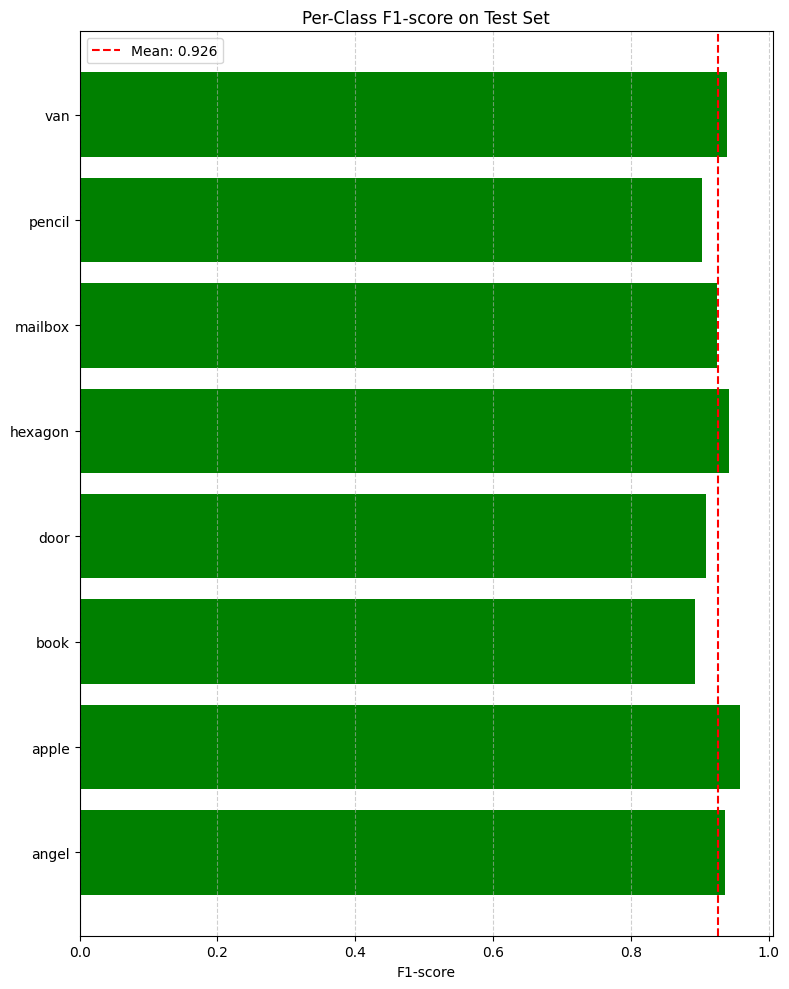

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_classes = df_report.iloc[:-3]

plt.figure(figsize=(8, 10))

plt.barh(
    df_classes.index,
    df_classes["f1-score"],
    color="green"
)

mean_f1 = df_classes["f1-score"].mean()
plt.axvline(mean_f1, color="red", linestyle="--", label=f"Mean: {mean_f1:.3f}")

plt.xlabel("F1-score")
plt.title("Per-Class F1-score on Test Set")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import Counter

true_names = [class_names[i] for i in y_test_true]
pred_names = [class_names[i] for i in y_test_pred]

errors = [
    f"{t} → {p}"
    for t, p in zip(true_names, pred_names)
    if t != p
]

error_counts = Counter(errors)


In [375]:
top_errors = error_counts.most_common(10)

pairs = [x[0] for x in top_errors]
counts = [x[1] for x in top_errors]


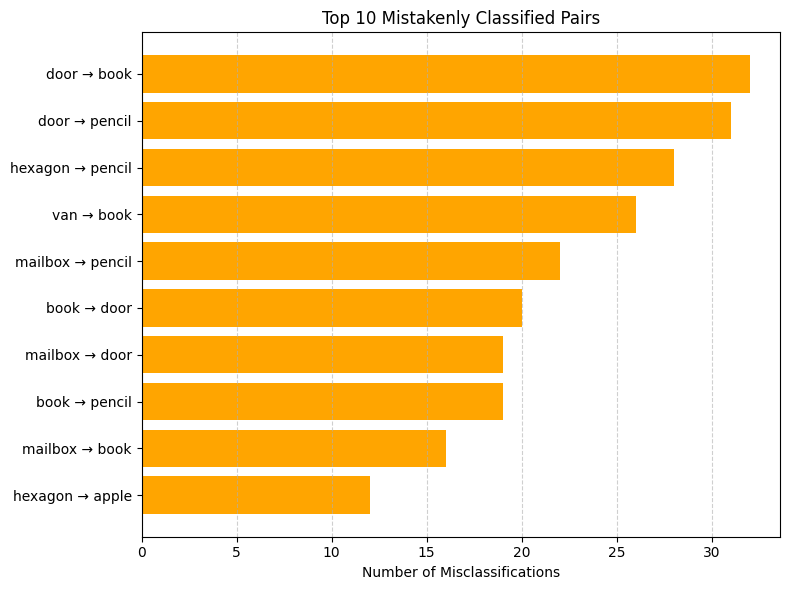

In [376]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.barh(
    pairs[::-1],
    counts[::-1],
    color="orange"
)

plt.xlabel("Number of Misclassifications")
plt.title("Top 10 Mistakenly Classified Pairs")
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


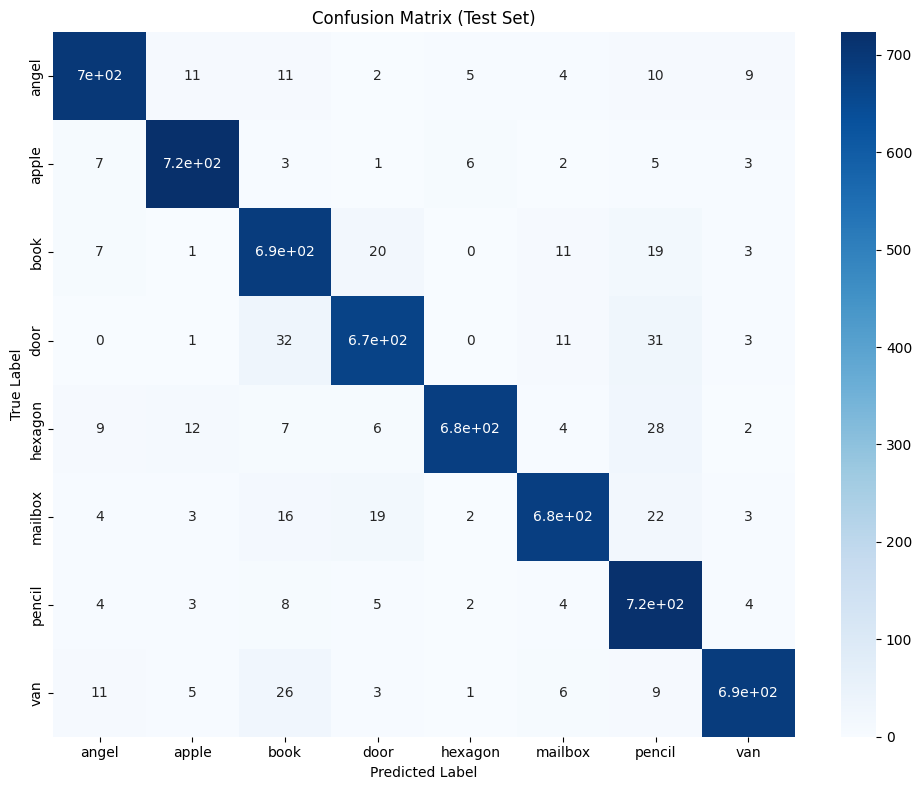

In [373]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    annot=True
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [ ]:
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

top_confusions = np.dstack(
    np.unravel_index(
        np.argsort(cm_no_diag.ravel())[::-1][:5],
        cm_no_diag.shape
    )
)[0]

print("Top confusions:")
for i, j in top_confusions:
    print(f"{class_names[i]} → {class_names[j]} : {cm[i, j]}")


Top confusions:
door → mailbox : 55
book → mailbox : 49
book → door : 48
angel → apple : 31
van → apple : 26
